In [1]:
# Filter tensorflow version warnings
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import gym
from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2

In [ ]:
## DEFAULT 'CarRacing-v2' environment values

ACT = [[0, 0, 0], [-0.4, 0, 0], [0.4, 0, 0], [0, 1, 0], [0, 0, 0.8]]
# discrete actions: center_steering and no gas/brake, left, right, accel, brake  
#     --> actually a good choice, because car_dynamics softens the action's diff for gas and steering

##REWARDS 
# reward given each step: step taken, distance to centerline, normalized speed [0-1], normalized steer angle [0-1]
# reward given on new tile touched: %proportional of advance, %advance/steps_taken
# reward given at episode end: all tiles touched (track finished), patience or off-raod exceeded, out of bounds, max_steps exceeded
GYM_REWARD = [ -0.1, 0.0, 0.0, 0.0,   10.0, 0.0,     0,  -0, -100, -0  ]
STD_REWARD = [ -0.1, 0.0, 0.0, 0.0,    1.0, 0.0,   100, -20, -100, -50 ]
# see docu for reward computation details

In [3]:
# My training
ACT = [[0, 0, 0], [-0.4, 0, 0], [0.4, 0, 0], [0, 0.6, 0], [0, 0, 0.8]]
MY_REWARD = [-0.0, 0.1, 0.0, 0.0,    1.0, 0.0,   100, -20, -100, -50]

env1 = gym.make('CarRacing-v2',
        game_color = 1,           # State (frame) color option: 0 = RGB, 1 = Grayscale, 2 = Green only
        indicators = True,        # show or not bottom Info Panel
        frames_per_state = 4,     # stacked (rolling history) Frames on each state [1-inf], latest observation always on first Frame
        skip_frames = 3,          # number of consecutive Frames to skip between state saves [0-4]
        discre = ACT,             # Action discretization function, format [[steer0, throtle0, brake0], [steer1, ...], ...]. None for continuous
        use_track = 100,            # number of times to use the same Track, [1-100]. More than 20 high risk of overfitting!!
        episodes_per_track = 15,   # number of evenly distributed starting points on each track [1-20]. Every time you call reset(), the env automatically starts at the next point
        tr_complexity = 12,       # generated Track geometric Complexity, [6-20]
        tr_width = 40,            # relative Track Width, [30-50]
        patience = 2.0,           # max time in secs without Progress, [0.5-20]
        off_track = 1.0,          # max time in secs Driving on Grass, [0.0-5]
        f_reward = MY_REWARD,     # reward funtion coeficients, refer to Docu for details
        verbose = 1      )

In [4]:
print(env1.action_space)
print(env1.observation_space)
env1.metadata

Discrete(5)
Box(0, 255, (96, 96, 4), uint8)


{'render.modes': ['human', 'rgb_array', 'state_pixels'],
 'FPS, 1/timebase': 33.333333333333336,
 'Zoom_level': 1.7,
 'Flight start': False,
 'show_track_1st': False,
 'state_pixels frame size': [96, 96]}

In [5]:
batch_size = 256
epochs = 4
updates = 1000

model = PPO2(CnnPolicy, env1, verbose=1, n_steps=batch_size, # seed=314, n_cpu_tf_sess=1,
             gamma=0.99, learning_rate=0.00025, nminibatches=epochs, ent_coef=0.01, vf_coef=0.5) 

model.learn(total_timesteps=updates*batch_size)


Wrapping the env in a DummyVecEnv.
Track generation: 988..1238 -> 250-tiles track, complex 12
--------------------------------------
| approxkl           | 0.0019286146  |
| clipfrac           | 0.0           |
| explained_variance | 0.0616        |
| fps                | 49            |
| n_updates          | 1             |
| policy_entropy     | 1.6076386     |
| policy_loss        | -0.0027806016 |
| serial_timesteps   | 256           |
| time_elapsed       | 0             |
| total_timesteps    | 256           |
| value_loss         | 1.0224539     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0013306846 |
| clipfrac           | 0.0          |
| explained_variance | -0.0212      |
| fps                | 58           |
| n_updates          | 2            |
| policy_entropy     | 1.6053871    |
| policy_loss        | -0.004469294 |
| serial_timesteps   | 512          |
| time_elapsed       | 5.16         |
| total_timesteps  

--------------------------------------
| approxkl           | 0.005209184   |
| clipfrac           | 0.09375       |
| explained_variance | 0.947         |
| fps                | 57            |
| n_updates          | 16            |
| policy_entropy     | 1.476383      |
| policy_loss        | -0.0039827162 |
| serial_timesteps   | 4096          |
| time_elapsed       | 66.9          |
| total_timesteps    | 4096          |
| value_loss         | 0.261415      |
--------------------------------------
12  cut by time without progress. Steps 317  %advance 5.6  played reward 24.58  last penalty -20
13  cut by time without progress. Steps 219  %advance 3.2  played reward 12.43  last penalty -20
--------------------------------------
| approxkl           | 0.004571835   |
| clipfrac           | 0.078125      |
| explained_variance | 0.614         |
| fps                | 54            |
| n_updates          | 17            |
| policy_entropy     | 1.5062206     |
| policy_loss        | -0.

19  cut by time without progress. Steps 426  %advance 4.8  played reward 31.68  last penalty -20
-------------------------------------
| approxkl           | 0.0022454443 |
| clipfrac           | 0.013671875  |
| explained_variance | 0.81         |
| fps                | 57           |
| n_updates          | 31           |
| policy_entropy     | 1.5383166    |
| policy_loss        | -0.004251222 |
| serial_timesteps   | 7936         |
| time_elapsed       | 134          |
| total_timesteps    | 7936         |
| value_loss         | 4.512863     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0061851013  |
| clipfrac           | 0.08984375    |
| explained_variance | 0.636         |
| fps                | 56            |
| n_updates          | 32            |
| policy_entropy     | 1.5703229     |
| policy_loss        | -0.0095384605 |
| serial_timesteps   | 8192          |
| time_elapsed       | 139           |
| total_timesteps  

31  cut by time without progress. Steps 366  %advance 6.8  played reward 34.74  last penalty -20
-------------------------------------
| approxkl           | 0.0072118663 |
| clipfrac           | 0.15136719   |
| explained_variance | 0.76         |
| fps                | 52           |
| n_updates          | 46           |
| policy_entropy     | 1.3862959    |
| policy_loss        | -0.010167859 |
| serial_timesteps   | 11776        |
| time_elapsed       | 202          |
| total_timesteps    | 11776        |
| value_loss         | 5.123858     |
-------------------------------------
32  cut by time without progress. Steps 170  %advance 2.0  played reward 15.75  last penalty -20
33  cut by time without progress. Steps 162  %advance 2.0  played reward 14.94  last penalty -20
---------------------------------------
| approxkl           | 0.0019054522   |
| clipfrac           | 0.0            |
| explained_variance | 0.051          |
| fps                | 51             |
| n_updates    

44  cut by time without progress. Steps 643  %advance 11.6  played reward 38.31  last penalty -20
-------------------------------------
| approxkl           | 0.004373355  |
| clipfrac           | 0.02734375   |
| explained_variance | 0.832        |
| fps                | 56           |
| n_updates          | 60           |
| policy_entropy     | 1.3007407    |
| policy_loss        | -0.003685031 |
| serial_timesteps   | 15360        |
| time_elapsed       | 266          |
| total_timesteps    | 15360        |
| value_loss         | 3.1305382    |
-------------------------------------
45  cut by time without progress. Steps 243  %advance 6.0  played reward 17.89  last penalty -20
46  cut by time without progress. Steps 149  %advance 6.8  played reward 6.68  last penalty -20
-------------------------------------
| approxkl           | 0.001240118  |
| clipfrac           | 0.0068359375 |
| explained_variance | 0.858        |
| fps                | 56           |
| n_updates          | 61

--------------------------------------
| approxkl           | 0.009343473   |
| clipfrac           | 0.15136719    |
| explained_variance | 0.693         |
| fps                | 56            |
| n_updates          | 74            |
| policy_entropy     | 1.3175716     |
| policy_loss        | -0.0126558645 |
| serial_timesteps   | 18944         |
| time_elapsed       | 329           |
| total_timesteps    | 18944         |
| value_loss         | 0.7977602     |
--------------------------------------
59  cut by time without progress. Steps 556  %advance 12.8  played reward 49.19  last penalty -20
60  cut by time without progress. Steps 174  %advance 6.0  played reward 18.61  last penalty -20
-------------------------------------
| approxkl           | 0.0045826575 |
| clipfrac           | 0.07421875   |
| explained_variance | 0.848        |
| fps                | 55           |
| n_updates          | 75           |
| policy_entropy     | 1.1102406    |
| policy_loss        | -0.008487

71  cut by time without progress. Steps 161  %advance 2.0  played reward 5.29  last penalty -20
72  cut by time without progress. Steps 189  %advance 4.8  played reward 11.64  last penalty -20
------------------------------------
| approxkl           | 0.005411518 |
| clipfrac           | 0.10839844  |
| explained_variance | 0.938       |
| fps                | 55          |
| n_updates          | 88          |
| policy_entropy     | 1.0904212   |
| policy_loss        | -0.00518115 |
| serial_timesteps   | 22528       |
| time_elapsed       | 392         |
| total_timesteps    | 22528       |
| value_loss         | 4.2623916   |
------------------------------------
73  cut by time without progress. Steps 242  %advance 4.0  played reward 10.2  last penalty -20
-------------------------------------
| approxkl           | 0.0033499787 |
| clipfrac           | 0.0029296875 |
| explained_variance | 0.983        |
| fps                | 56           |
| n_updates          | 89           |
| 

-------------------------------------
| approxkl           | 0.0062900833 |
| clipfrac           | 0.06640625   |
| explained_variance | 0.773        |
| fps                | 56           |
| n_updates          | 103          |
| policy_entropy     | 1.2378215    |
| policy_loss        | -0.00606498  |
| serial_timesteps   | 26368        |
| time_elapsed       | 460          |
| total_timesteps    | 26368        |
| value_loss         | 0.24442242   |
-------------------------------------
-------------------------------------
| approxkl           | 0.005085955  |
| clipfrac           | 0.040039062  |
| explained_variance | 0.627        |
| fps                | 57           |
| n_updates          | 104          |
| policy_entropy     | 1.3999568    |
| policy_loss        | 0.0004963294 |
| serial_timesteps   | 26624        |
| time_elapsed       | 465          |
| total_timesteps    | 26624        |
| value_loss         | 0.37594786   |
-------------------------------------
80  cut by t

91  cut by time without progress. Steps 348  %advance 7.6  played reward 22.75  last penalty -20
--------------------------------------
| approxkl           | 0.0056757643  |
| clipfrac           | 0.06933594    |
| explained_variance | 0.98          |
| fps                | 57            |
| n_updates          | 118           |
| policy_entropy     | 1.1234522     |
| policy_loss        | -0.0023020075 |
| serial_timesteps   | 30208         |
| time_elapsed       | 528           |
| total_timesteps    | 30208         |
| value_loss         | 0.54990244    |
--------------------------------------
--------------------------------------
| approxkl           | 0.005242646   |
| clipfrac           | 0.06738281    |
| explained_variance | 0.327         |
| fps                | 58            |
| n_updates          | 119           |
| policy_entropy     | 1.2547954     |
| policy_loss        | -0.0023080306 |
| serial_timesteps   | 30464         |
| time_elapsed       | 533           |
| tota

102  cut by time without progress. Steps 262  %advance 3.6  played reward 25.08  last penalty -20
-------------------------------------
| approxkl           | 0.0018352913 |
| clipfrac           | 0.0068359375 |
| explained_variance | 0.447        |
| fps                | 54           |
| n_updates          | 133          |
| policy_entropy     | 1.4758574    |
| policy_loss        | -0.005174539 |
| serial_timesteps   | 34048        |
| time_elapsed       | 596          |
| total_timesteps    | 34048        |
| value_loss         | 8.118597     |
-------------------------------------
103  cut by time without progress. Steps 160  %advance 1.6  played reward 14.87  last penalty -20
--------------------------------------
| approxkl           | 0.005433226   |
| clipfrac           | 0.051757812   |
| explained_variance | 0.179         |
| fps                | 57            |
| n_updates          | 134           |
| policy_entropy     | 1.4114593     |
| policy_loss        | -0.0074974997 

-------------------------------------
| approxkl           | 0.005965325  |
| clipfrac           | 0.091796875  |
| explained_variance | 0.982        |
| fps                | 58           |
| n_updates          | 147          |
| policy_entropy     | 1.479188     |
| policy_loss        | -0.011445196 |
| serial_timesteps   | 37632        |
| time_elapsed       | 659          |
| total_timesteps    | 37632        |
| value_loss         | 0.65794677   |
-------------------------------------
115  cut by time without progress. Steps 183  %advance 3.6  played reward 18.18  last penalty -20
-------------------------------------
| approxkl           | 0.0049410993 |
| clipfrac           | 0.0625       |
| explained_variance | 0.298        |
| fps                | 56           |
| n_updates          | 148          |
| policy_entropy     | 1.4134992    |
| policy_loss        | -0.006509107 |
| serial_timesteps   | 37888        |
| time_elapsed       | 663          |
| total_timesteps    | 37888

126  cut by time without progress. Steps 220  %advance 4.0  played reward 12.98  last penalty -20
--------------------------------------
| approxkl           | 0.0031183274  |
| clipfrac           | 0.0234375     |
| explained_variance | 0.983         |
| fps                | 56            |
| n_updates          | 162           |
| policy_entropy     | 1.397564      |
| policy_loss        | -0.0026612794 |
| serial_timesteps   | 41472         |
| time_elapsed       | 727           |
| total_timesteps    | 41472         |
| value_loss         | 0.7634011     |
--------------------------------------
127  cut by time without progress. Steps 281  %advance 10.0  played reward 22.0  last penalty -20
--------------------------------------
| approxkl           | 0.0041316412  |
| clipfrac           | 0.037109375   |
| explained_variance | 0.989         |
| fps                | 56            |
| n_updates          | 163           |
| policy_entropy     | 1.4319074     |
| policy_loss        | -

-------------------------------------
| approxkl           | 0.01135545   |
| clipfrac           | 0.21679688   |
| explained_variance | 0.949        |
| fps                | 57           |
| n_updates          | 177          |
| policy_entropy     | 1.4686207    |
| policy_loss        | -0.014467621 |
| serial_timesteps   | 45312        |
| time_elapsed       | 794          |
| total_timesteps    | 45312        |
| value_loss         | 0.34221983   |
-------------------------------------
-------------------------------------
| approxkl           | 0.010779458  |
| clipfrac           | 0.1640625    |
| explained_variance | 0.927        |
| fps                | 56           |
| n_updates          | 178          |
| policy_entropy     | 1.4553013    |
| policy_loss        | -0.006610574 |
| serial_timesteps   | 45568        |
| time_elapsed       | 799          |
| total_timesteps    | 45568        |
| value_loss         | 0.7789514    |
-------------------------------------
137  cut by 

149  cut by time without progress. Steps 658  %advance 6.8  played reward 58.84  last penalty -20
-------------------------------------
| approxkl           | 0.008114908  |
| clipfrac           | 0.13671875   |
| explained_variance | 0.254        |
| fps                | 57           |
| n_updates          | 192          |
| policy_entropy     | 1.3615876    |
| policy_loss        | 0.0014987038 |
| serial_timesteps   | 49152        |
| time_elapsed       | 862          |
| total_timesteps    | 49152        |
| value_loss         | 8.605822     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0052806586 |
| clipfrac           | 0.05859375   |
| explained_variance | 0.912        |
| fps                | 56           |
| n_updates          | 193          |
| policy_entropy     | 1.3844564    |
| policy_loss        | -0.005719475 |
| serial_timesteps   | 49408        |
| time_elapsed       | 867          |
| total_timesteps    | 49408

168  cut by time without progress. Steps 444  %advance 4.0  played reward 40.75  last penalty -20
--------------------------------------
| approxkl           | 0.007914986   |
| clipfrac           | 0.10546875    |
| explained_variance | 0.128         |
| fps                | 55            |
| n_updates          | 205           |
| policy_entropy     | 1.4558518     |
| policy_loss        | -0.0067496016 |
| serial_timesteps   | 52480         |
| time_elapsed       | 922           |
| total_timesteps    | 52480         |
| value_loss         | 9.712879      |
--------------------------------------
169  cut by time without progress. Steps 134  %advance 1.6  played reward 12.63  last penalty -20
170  cut by time without progress. Steps 154  %advance 1.6  played reward 13.67  last penalty -20
-------------------------------------
| approxkl           | 0.0034151557 |
| clipfrac           | 0.033203125  |
| explained_variance | 0.216        |
| fps                | 48           |
| n_updat

--------------------------------------
| approxkl           | 0.0019793902  |
| clipfrac           | 0.0146484375  |
| explained_variance | 0.0573        |
| fps                | 47            |
| n_updates          | 218           |
| policy_entropy     | 1.4032754     |
| policy_loss        | -0.0052253306 |
| serial_timesteps   | 55808         |
| time_elapsed       | 988           |
| total_timesteps    | 55808         |
| value_loss         | 22.897318     |
--------------------------------------
186  cut by time without progress. Steps 107  %advance 1.2  played reward 10.14  last penalty -20
187  cut by time without progress. Steps 113  %advance 1.2  played reward 10.53  last penalty -20
188  cut by time without progress. Steps 102  %advance 1.2  played reward 9.0  last penalty -20
--------------------------------------
| approxkl           | 0.0063666785  |
| clipfrac           | 0.057617188   |
| explained_variance | 0.0663        |
| fps                | 48            |
| n_up

199  cut by time without progress. Steps 80  %advance 1.2  played reward 7.27  last penalty -20
--------------------------------------
| approxkl           | 0.0071662115  |
| clipfrac           | 0.083984375   |
| explained_variance | 0.107         |
| fps                | 54            |
| n_updates          | 232           |
| policy_entropy     | 1.3829383     |
| policy_loss        | -0.0009066467 |
| serial_timesteps   | 59392         |
| time_elapsed       | 1.06e+03      |
| total_timesteps    | 59392         |
| value_loss         | 21.187145     |
--------------------------------------
200  cut by time without progress. Steps 166  %advance 1.6  played reward 15.2  last penalty -20
-------------------------------------
| approxkl           | 0.0038614294 |
| clipfrac           | 0.030273438  |
| explained_variance | 0.109        |
| fps                | 54           |
| n_updates          | 233          |
| policy_entropy     | 1.4708043    |
| policy_loss        | -0.00862564

--------------------------------------
| approxkl           | 0.010699093   |
| clipfrac           | 0.19140625    |
| explained_variance | 0.77          |
| fps                | 56            |
| n_updates          | 246           |
| policy_entropy     | 1.510067      |
| policy_loss        | -0.0143335145 |
| serial_timesteps   | 62976         |
| time_elapsed       | 1.12e+03      |
| total_timesteps    | 62976         |
| value_loss         | 0.15654287    |
--------------------------------------
212  cut by time without progress. Steps 394  %advance 6.8  played reward 38.9  last penalty -20
-------------------------------------
| approxkl           | 0.0024844792 |
| clipfrac           | 0.0029296875 |
| explained_variance | 0.151        |
| fps                | 55           |
| n_updates          | 247          |
| policy_entropy     | 1.5484928    |
| policy_loss        | 0.0030291565 |
| serial_timesteps   | 63232        |
| time_elapsed       | 1.13e+03     |
| total_timestep

219  cut by time without progress. Steps 580  %advance 14.4  played reward 61.95  last penalty -20
--------------------------------------
| approxkl           | 0.015329758   |
| clipfrac           | 0.140625      |
| explained_variance | 0.807         |
| fps                | 54            |
| n_updates          | 262           |
| policy_entropy     | 1.3865898     |
| policy_loss        | -0.0010666829 |
| serial_timesteps   | 67072         |
| time_elapsed       | 1.2e+03       |
| total_timesteps    | 67072         |
| value_loss         | 4.301819      |
--------------------------------------
220  cut by time without progress. Steps 403  %advance 8.0  played reward 41.11  last penalty -20
--------------------------------------
| approxkl           | 0.006158703   |
| clipfrac           | 0.083984375   |
| explained_variance | 0.622         |
| fps                | 55            |
| n_updates          | 263           |
| policy_entropy     | 1.523613      |
| policy_loss        | 

-------------------------------------
| approxkl           | 0.01162074   |
| clipfrac           | 0.17285156   |
| explained_variance | -0.213       |
| fps                | 55           |
| n_updates          | 278          |
| policy_entropy     | 1.1964173    |
| policy_loss        | -0.009664826 |
| serial_timesteps   | 71168        |
| time_elapsed       | 1.27e+03     |
| total_timesteps    | 71168        |
| value_loss         | 1.2357541    |
-------------------------------------
---------------------------------------
| approxkl           | 0.009137001    |
| clipfrac           | 0.12792969     |
| explained_variance | 0.599          |
| fps                | 56             |
| n_updates          | 279            |
| policy_entropy     | 1.1504674      |
| policy_loss        | -0.00065706123 |
| serial_timesteps   | 71424          |
| time_elapsed       | 1.27e+03       |
| total_timesteps    | 71424          |
| value_loss         | 4.426881       |
--------------------------

-------------------------------------
| approxkl           | 0.019844977  |
| clipfrac           | 0.23242188   |
| explained_variance | -0.486       |
| fps                | 55           |
| n_updates          | 294          |
| policy_entropy     | 0.81232804   |
| policy_loss        | -0.008152237 |
| serial_timesteps   | 75264        |
| time_elapsed       | 1.34e+03     |
| total_timesteps    | 75264        |
| value_loss         | 0.13743861   |
-------------------------------------
231  cut by time without progress. Steps 953  %advance 34.5  played reward 107.21  last penalty -20
--------------------------------------
| approxkl           | 0.0064746486  |
| clipfrac           | 0.095703125   |
| explained_variance | 0.925         |
| fps                | 55            |
| n_updates          | 295           |
| policy_entropy     | 0.9222926     |
| policy_loss        | -0.0011662658 |
| serial_timesteps   | 75520         |
| time_elapsed       | 1.35e+03      |
| total_timestep

--------------------------------------
| approxkl           | 0.021595668   |
| clipfrac           | 0.19140625    |
| explained_variance | -1.35         |
| fps                | 56            |
| n_updates          | 310           |
| policy_entropy     | 0.92716026    |
| policy_loss        | -0.0012490591 |
| serial_timesteps   | 79360         |
| time_elapsed       | 1.42e+03      |
| total_timesteps    | 79360         |
| value_loss         | 0.41103914    |
--------------------------------------
235  env max steps reached 1000  %advance 79.1  played reward 156.27  last penalty -50
236  cut by time without progress. Steps 67  %advance 0.8  played reward 6.59  last penalty -20
------------------------------------
| approxkl           | 0.011828962 |
| clipfrac           | 0.15039062  |
| explained_variance | 0.025       |
| fps                | 52          |
| n_updates          | 311         |
| policy_entropy     | 0.8523464   |
| policy_loss        | -0.01445437 |
| serial_times

240  cut by time without progress. Steps 941  %advance 84.7  played reward 148.63  last penalty -20
-------------------------------------
| approxkl           | 0.0060794684 |
| clipfrac           | 0.099609375  |
| explained_variance | 0.516        |
| fps                | 55           |
| n_updates          | 326          |
| policy_entropy     | 0.8389736    |
| policy_loss        | 0.004494511  |
| serial_timesteps   | 83456        |
| time_elapsed       | 1.49e+03     |
| total_timesteps    | 83456        |
| value_loss         | 20.705935    |
-------------------------------------
----------------------------------------
| approxkl           | 0.0051725227    |
| clipfrac           | 0.064453125     |
| explained_variance | -0.538          |
| fps                | 55              |
| n_updates          | 327             |
| policy_entropy     | 1.1620812       |
| policy_loss        | -0.000116553856 |
| serial_timesteps   | 83712           |
| time_elapsed       | 1.5e+03       

--------------------------------------
| approxkl           | 0.012967157   |
| clipfrac           | 0.14453125    |
| explained_variance | 0.262         |
| fps                | 53            |
| n_updates          | 342           |
| policy_entropy     | 0.843113      |
| policy_loss        | -0.0047977366 |
| serial_timesteps   | 87552         |
| time_elapsed       | 1.57e+03      |
| total_timesteps    | 87552         |
| value_loss         | 0.07773189    |
--------------------------------------
------------------------------------
| approxkl           | 0.018531065 |
| clipfrac           | 0.23046875  |
| explained_variance | -1.91       |
| fps                | 54          |
| n_updates          | 343         |
| policy_entropy     | 0.8612666   |
| policy_loss        | -0.00932266 |
| serial_timesteps   | 87808       |
| time_elapsed       | 1.57e+03    |
| total_timesteps    | 87808       |
| value_loss         | 0.100606225 |
------------------------------------
245  env max

-------------------------------------
| approxkl           | 0.0091331685 |
| clipfrac           | 0.14648438   |
| explained_variance | -0.0629      |
| fps                | 55           |
| n_updates          | 358          |
| policy_entropy     | 0.9616829    |
| policy_loss        | -0.002643649 |
| serial_timesteps   | 91648        |
| time_elapsed       | 1.64e+03     |
| total_timesteps    | 91648        |
| value_loss         | 0.03948373   |
-------------------------------------
-------------------------------------
| approxkl           | 0.01351826   |
| clipfrac           | 0.15429688   |
| explained_variance | -7.51e-05    |
| fps                | 56           |
| n_updates          | 359          |
| policy_entropy     | 0.9620939    |
| policy_loss        | -0.008793787 |
| serial_timesteps   | 91904        |
| time_elapsed       | 1.65e+03     |
| total_timesteps    | 91904        |
| value_loss         | 0.059951015  |
-------------------------------------
250  env max

-------------------------------------
| approxkl           | 0.011980695  |
| clipfrac           | 0.15820312   |
| explained_variance | 0.569        |
| fps                | 55           |
| n_updates          | 374          |
| policy_entropy     | 1.0577371    |
| policy_loss        | -0.008041274 |
| serial_timesteps   | 95744        |
| time_elapsed       | 1.72e+03     |
| total_timesteps    | 95744        |
| value_loss         | 0.0906373    |
-------------------------------------
--------------------------------------
| approxkl           | 0.012422956   |
| clipfrac           | 0.20410156    |
| explained_variance | 0.203         |
| fps                | 55            |
| n_updates          | 375           |
| policy_entropy     | 0.963618      |
| policy_loss        | -0.0048710774 |
| serial_timesteps   | 96000         |
| time_elapsed       | 1.72e+03      |
| total_timesteps    | 96000         |
| value_loss         | 0.45125058    |
--------------------------------------

--------------------------------------
| approxkl           | 0.004992195   |
| clipfrac           | 0.068359375   |
| explained_variance | 0.35          |
| fps                | 56            |
| n_updates          | 390           |
| policy_entropy     | 0.6977111     |
| policy_loss        | -0.0057114214 |
| serial_timesteps   | 99840         |
| time_elapsed       | 1.79e+03      |
| total_timesteps    | 99840         |
| value_loss         | 2.9620917     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0035225586 |
| clipfrac           | 0.043945312  |
| explained_variance | 0.599        |
| fps                | 55           |
| n_updates          | 391          |
| policy_entropy     | 0.7308398    |
| policy_loss        | -0.00458193  |
| serial_timesteps   | 100096       |
| time_elapsed       | 1.8e+03      |
| total_timesteps    | 100096       |
| value_loss         | 2.517428     |
-------------------------------------

270  cut by time without progress. Steps 427  %advance 47.3  played reward 64.83  last penalty -20
-------------------------------------
| approxkl           | 0.011769578  |
| clipfrac           | 0.16308594   |
| explained_variance | 0.84         |
| fps                | 55           |
| n_updates          | 406          |
| policy_entropy     | 0.96121943   |
| policy_loss        | -0.000260005 |
| serial_timesteps   | 103936       |
| time_elapsed       | 1.87e+03     |
| total_timesteps    | 103936       |
| value_loss         | 11.778893    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0042538536  |
| clipfrac           | 0.047851562   |
| explained_variance | 0.267         |
| fps                | 52            |
| n_updates          | 407           |
| policy_entropy     | 0.6289616     |
| policy_loss        | -0.0064412006 |
| serial_timesteps   | 104192        |
| time_elapsed       | 1.87e+03      |
| total_timesteps

282  cut by time without progress. Steps 329  %advance 41.3  played reward 52.25  last penalty -20
-------------------------------------
| approxkl           | 0.0074349577 |
| clipfrac           | 0.109375     |
| explained_variance | 0.879        |
| fps                | 54           |
| n_updates          | 421          |
| policy_entropy     | 0.7727055    |
| policy_loss        | -0.008263031 |
| serial_timesteps   | 107776       |
| time_elapsed       | 1.94e+03     |
| total_timesteps    | 107776       |
| value_loss         | 8.819439     |
-------------------------------------
283  cut by time without progress. Steps 253  %advance 25.3  played reward 32.57  last penalty -20
-------------------------------------
| approxkl           | 0.0055000586 |
| clipfrac           | 0.0859375    |
| explained_variance | 0.937        |
| fps                | 55           |
| n_updates          | 422          |
| policy_entropy     | 0.79604906   |
| policy_loss        | -0.010936234 |
| se

293  cut by time without progress. Steps 234  %advance 25.7  played reward 30.49  last penalty -20
--------------------------------------
| approxkl           | 0.0054755257  |
| clipfrac           | 0.080078125   |
| explained_variance | 0.953         |
| fps                | 55            |
| n_updates          | 436           |
| policy_entropy     | 0.72132397    |
| policy_loss        | -0.0023830417 |
| serial_timesteps   | 111616        |
| time_elapsed       | 2.01e+03      |
| total_timesteps    | 111616        |
| value_loss         | 7.6733985     |
--------------------------------------
294  cut by time without progress. Steps 212  %advance 18.0  played reward 19.99  last penalty -20
-------------------------------------
| approxkl           | 0.0025604847 |
| clipfrac           | 0.02734375   |
| explained_variance | 0.877        |
| fps                | 55           |
| n_updates          | 437          |
| policy_entropy     | 0.8783353    |
| policy_loss        | -0.006

305  cut by time without progress. Steps 364  %advance 50.2  played reward 66.91  last penalty -20
-------------------------------------
| approxkl           | 0.0054793847 |
| clipfrac           | 0.07910156   |
| explained_variance | 0.962        |
| fps                | 56           |
| n_updates          | 451          |
| policy_entropy     | 0.9779543    |
| policy_loss        | -0.010453281 |
| serial_timesteps   | 115456       |
| time_elapsed       | 2.08e+03     |
| total_timesteps    | 115456       |
| value_loss         | 5.328858     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0032054149 |
| clipfrac           | 0.044921875  |
| explained_variance | 0.052        |
| fps                | 55           |
| n_updates          | 452          |
| policy_entropy     | 0.7845644    |
| policy_loss        | -0.011740786 |
| serial_timesteps   | 115712       |
| time_elapsed       | 2.08e+03     |
| total_timesteps    | 1157

-------------------------------------
| approxkl           | 0.008490307  |
| clipfrac           | 0.12207031   |
| explained_variance | 0.451        |
| fps                | 56           |
| n_updates          | 467          |
| policy_entropy     | 0.70965403   |
| policy_loss        | -0.004654098 |
| serial_timesteps   | 119552       |
| time_elapsed       | 2.15e+03     |
| total_timesteps    | 119552       |
| value_loss         | 0.42042673   |
-------------------------------------
312  cut by time without progress. Steps 647  %advance 95.9  played reward 131.63  last penalty -20
-------------------------------------
| approxkl           | 0.009334992  |
| clipfrac           | 0.11425781   |
| explained_variance | 0.688        |
| fps                | 56           |
| n_updates          | 468          |
| policy_entropy     | 0.98788744   |
| policy_loss        | -0.010918858 |
| serial_timesteps   | 119808       |
| time_elapsed       | 2.16e+03     |
| total_timesteps    | 119

--------------------------------------
| approxkl           | 0.0061623165  |
| clipfrac           | 0.080078125   |
| explained_variance | 0.722         |
| fps                | 55            |
| n_updates          | 483           |
| policy_entropy     | 0.77377146    |
| policy_loss        | -0.0049368306 |
| serial_timesteps   | 123648        |
| time_elapsed       | 2.23e+03      |
| total_timesteps    | 123648        |
| value_loss         | 0.3998622     |
--------------------------------------
320  cut by time without progress. Steps 334  %advance 40.9  played reward 56.31  last penalty -20
-------------------------------------
| approxkl           | 0.011580811  |
| clipfrac           | 0.15136719   |
| explained_variance | 0.948        |
| fps                | 55           |
| n_updates          | 484          |
| policy_entropy     | 0.86393327   |
| policy_loss        | -0.020457065 |
| serial_timesteps   | 123904       |
| time_elapsed       | 2.23e+03     |
| total_timest

-------------------------------------
| approxkl           | 0.013141274  |
| clipfrac           | 0.09863281   |
| explained_variance | 0.93         |
| fps                | 56           |
| n_updates          | 498          |
| policy_entropy     | 0.65496624   |
| policy_loss        | 0.0014240401 |
| serial_timesteps   | 127488       |
| time_elapsed       | 2.29e+03     |
| total_timesteps    | 127488       |
| value_loss         | 0.39240232   |
-------------------------------------
--------------------------------------
| approxkl           | 0.0050700987  |
| clipfrac           | 0.060546875   |
| explained_variance | 0.428         |
| fps                | 56            |
| n_updates          | 499           |
| policy_entropy     | 0.4900896     |
| policy_loss        | -0.0015510558 |
| serial_timesteps   | 127744        |
| time_elapsed       | 2.3e+03       |
| total_timesteps    | 127744        |
| value_loss         | 1.2376833     |
--------------------------------------

338  cut by time without progress. Steps 213  %advance 21.2  played reward 24.16  last penalty -20
-------------------------------------
| approxkl           | 0.008819911  |
| clipfrac           | 0.13574219   |
| explained_variance | 0.891        |
| fps                | 51           |
| n_updates          | 513          |
| policy_entropy     | 0.83166254   |
| policy_loss        | -0.004660923 |
| serial_timesteps   | 131328       |
| time_elapsed       | 2.36e+03     |
| total_timesteps    | 131328       |
| value_loss         | 27.834242    |
-------------------------------------
339  cut by time without progress. Steps 190  %advance 18.8  played reward 19.88  last penalty -20
340  cut by time without progress. Steps 196  %advance 18.4  played reward 21.06  last penalty -20
--------------------------------------
| approxkl           | 0.015919242   |
| clipfrac           | 0.20019531    |
| explained_variance | 0.937         |
| fps                | 52            |
| n_updates   

--------------------------------------
| approxkl           | 0.002132248   |
| clipfrac           | 0.022460938   |
| explained_variance | 0.861         |
| fps                | 55            |
| n_updates          | 528           |
| policy_entropy     | 0.56584215    |
| policy_loss        | -0.0067844596 |
| serial_timesteps   | 135168        |
| time_elapsed       | 2.43e+03      |
| total_timesteps    | 135168        |
| value_loss         | 7.161818      |
--------------------------------------
350  cut by time without progress. Steps 337  %advance 50.2  played reward 63.64  last penalty -20
-------------------------------------
| approxkl           | 0.012155465  |
| clipfrac           | 0.13476562   |
| explained_variance | 0.997        |
| fps                | 56           |
| n_updates          | 529          |
| policy_entropy     | 0.72804564   |
| policy_loss        | -0.010649608 |
| serial_timesteps   | 135424       |
| time_elapsed       | 2.44e+03     |
| total_timest

358  Finalized in Steps 694  with return=total reward 250.57780136558893
-------------------------------------
| approxkl           | 0.009465157  |
| clipfrac           | 0.07910156   |
| explained_variance | -0.188       |
| fps                | 56           |
| n_updates          | 543          |
| policy_entropy     | 0.6728785    |
| policy_loss        | -0.008754875 |
| serial_timesteps   | 139008       |
| time_elapsed       | 2.5e+03      |
| total_timesteps    | 139008       |
| value_loss         | 123.27357    |
-------------------------------------
-------------------------------------
| approxkl           | 0.04432778   |
| clipfrac           | 0.28027344   |
| explained_variance | 0.0986       |
| fps                | 56           |
| n_updates          | 544          |
| policy_entropy     | 0.61332124   |
| policy_loss        | -0.023261577 |
| serial_timesteps   | 139264       |
| time_elapsed       | 2.51e+03     |
| total_timesteps    | 139264       |
| value_loss   

--------------------------------------
| approxkl           | 0.0069867237  |
| clipfrac           | 0.083984375   |
| explained_variance | -0.276        |
| fps                | 56            |
| n_updates          | 559           |
| policy_entropy     | 0.34276688    |
| policy_loss        | -0.0037756504 |
| serial_timesteps   | 143104        |
| time_elapsed       | 2.57e+03      |
| total_timesteps    | 143104        |
| value_loss         | 2.101953      |
--------------------------------------
366  Finalized in Steps 537  with return=total reward 239.23214440990535
-------------------------------------
| approxkl           | 0.0009476653 |
| clipfrac           | 0.0107421875 |
| explained_variance | 0.0724       |
| fps                | 55           |
| n_updates          | 560          |
| policy_entropy     | 0.46485496   |
| policy_loss        | 0.0009560061 |
| serial_timesteps   | 143360       |
| time_elapsed       | 2.58e+03     |
| total_timesteps    | 143360       |
| 

-------------------------------------
| approxkl           | 0.00747517   |
| clipfrac           | 0.06347656   |
| explained_variance | 0.862        |
| fps                | 56           |
| n_updates          | 574          |
| policy_entropy     | 0.37741643   |
| policy_loss        | -0.008741414 |
| serial_timesteps   | 146944       |
| time_elapsed       | 2.64e+03     |
| total_timesteps    | 146944       |
| value_loss         | 17.92151     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0013102066 |
| clipfrac           | 0.016601562  |
| explained_variance | 0.0135       |
| fps                | 56           |
| n_updates          | 575          |
| policy_entropy     | 0.2227796    |
| policy_loss        | 0.0023055251 |
| serial_timesteps   | 147200       |
| time_elapsed       | 2.65e+03     |
| total_timesteps    | 147200       |
| value_loss         | 0.50567716   |
-------------------------------------
375  Finaliz

384  Finalized in Steps 480  with return=total reward 234.55200089649256
--------------------------------------
| approxkl           | 0.0032117073  |
| clipfrac           | 0.032226562   |
| explained_variance | 0.0637        |
| fps                | 55            |
| n_updates          | 589           |
| policy_entropy     | 0.15771963    |
| policy_loss        | -0.0034166453 |
| serial_timesteps   | 150784        |
| time_elapsed       | 2.71e+03      |
| total_timesteps    | 150784        |
| value_loss         | 89.87056      |
--------------------------------------
385  cut by time without progress. Steps 176  %advance 18.8  played reward 19.93  last penalty -20
-------------------------------------
| approxkl           | 0.013830289  |
| clipfrac           | 0.12988281   |
| explained_variance | 0.837        |
| fps                | 56           |
| n_updates          | 590          |
| policy_entropy     | 0.43933663   |
| policy_loss        | -0.010436392 |
| serial_timestep

393  cut by time without progress. Steps 324  %advance 53.8  played reward 66.26  last penalty -20
-------------------------------------
| approxkl           | 0.007460695  |
| clipfrac           | 0.11328125   |
| explained_variance | 0.907        |
| fps                | 56           |
| n_updates          | 604          |
| policy_entropy     | 0.46537942   |
| policy_loss        | 0.0016291926 |
| serial_timesteps   | 154624       |
| time_elapsed       | 2.78e+03     |
| total_timesteps    | 154624       |
| value_loss         | 15.083969    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0028999988 |
| clipfrac           | 0.02734375   |
| explained_variance | 0.657        |
| fps                | 55           |
| n_updates          | 605          |
| policy_entropy     | 0.21761756   |
| policy_loss        | 0.0039153122 |
| serial_timesteps   | 154880       |
| time_elapsed       | 2.79e+03     |
| total_timesteps    | 1548

--------------------------------------
| approxkl           | 0.004529072   |
| clipfrac           | 0.061523438   |
| explained_variance | -0.309        |
| fps                | 50            |
| n_updates          | 619           |
| policy_entropy     | 0.18650784    |
| policy_loss        | -0.0018383726 |
| serial_timesteps   | 158464        |
| time_elapsed       | 2.85e+03      |
| total_timesteps    | 158464        |
| value_loss         | 0.4892873     |
--------------------------------------
403  cut by time without progress. Steps 548  %advance 97.9  played reward 126.69  last penalty -20
-------------------------------------
| approxkl           | 0.0027367044 |
| clipfrac           | 0.024414062  |
| explained_variance | 0.817        |
| fps                | 49           |
| n_updates          | 620          |
| policy_entropy     | 0.28363687   |
| policy_loss        | 0.0005909011 |
| serial_timesteps   | 158720       |
| time_elapsed       | 2.86e+03     |
| total_times

410  cut by time without progress. Steps 542  %advance 99.5  played reward 137.26  last penalty -20
--------------------------------------
| approxkl           | 0.0013957913  |
| clipfrac           | 0.022460938   |
| explained_variance | -0.103        |
| fps                | 44            |
| n_updates          | 634           |
| policy_entropy     | 0.21836948    |
| policy_loss        | -0.0003629558 |
| serial_timesteps   | 162304        |
| time_elapsed       | 2.93e+03      |
| total_timesteps    | 162304        |
| value_loss         | 42.54535      |
--------------------------------------
411  cut by time without progress. Steps 296  %advance 44.1  played reward 55.22  last penalty -20
--------------------------------------
| approxkl           | 0.0034365733  |
| clipfrac           | 0.044921875   |
| explained_variance | 0.884         |
| fps                | 39            |
| n_updates          | 635           |
| policy_entropy     | 0.29762378    |
| policy_loss        

--------------------------------------
| approxkl           | 0.00259834    |
| clipfrac           | 0.030273438   |
| explained_variance | -0.71         |
| fps                | 43            |
| n_updates          | 649           |
| policy_entropy     | 0.19076844    |
| policy_loss        | -0.0018640629 |
| serial_timesteps   | 166144        |
| time_elapsed       | 3.01e+03      |
| total_timesteps    | 166144        |
| value_loss         | 0.19935274    |
--------------------------------------
421  cut by time without progress. Steps 395  %advance 67.0  played reward 84.87  last penalty -20
------------------------------------
| approxkl           | 0.010431843 |
| clipfrac           | 0.08300781  |
| explained_variance | 0.68        |
| fps                | 47          |
| n_updates          | 650         |
| policy_entropy     | 0.23558912  |
| policy_loss        | -0.01443239 |
| serial_timesteps   | 166400      |
| time_elapsed       | 3.02e+03    |
| total_timesteps    | 1

430  Finalized in Steps 478  with return=total reward 235.17628367807515
-------------------------------------
| approxkl           | 0.0029859047 |
| clipfrac           | 0.028320312  |
| explained_variance | 0.196        |
| fps                | 44           |
| n_updates          | 664          |
| policy_entropy     | 0.17099215   |
| policy_loss        | -0.006593304 |
| serial_timesteps   | 169984       |
| time_elapsed       | 3.1e+03      |
| total_timesteps    | 169984       |
| value_loss         | 92.37929     |
-------------------------------------
431  cut by time without progress. Steps 67  %advance 0.8  played reward 6.59  last penalty -20
--------------------------------------
| approxkl           | 0.0024181718  |
| clipfrac           | 0.016601562   |
| explained_variance | 0.553         |
| fps                | 46            |
| n_updates          | 665           |
| policy_entropy     | 0.1965997     |
| policy_loss        | -0.0020050686 |
| serial_timesteps   | 17

439  cut by time without progress. Steps 366  %advance 60.2  played reward 74.49  last penalty -20
-------------------------------------
| approxkl           | 0.0038546706 |
| clipfrac           | 0.048828125  |
| explained_variance | 0.865        |
| fps                | 50           |
| n_updates          | 679          |
| policy_entropy     | 0.23089918   |
| policy_loss        | -0.003178091 |
| serial_timesteps   | 173824       |
| time_elapsed       | 3.18e+03     |
| total_timesteps    | 173824       |
| value_loss         | 14.023366    |
-------------------------------------
440  cut by time without progress. Steps 337  %advance 53.8  played reward 69.47  last penalty -20
--------------------------------------
| approxkl           | 0.008477928   |
| clipfrac           | 0.107421875   |
| explained_variance | 0.61          |
| fps                | 50            |
| n_updates          | 680           |
| policy_entropy     | 0.3448382     |
| policy_loss        | 0.0003126384

-------------------------------------
| approxkl           | 0.002937544  |
| clipfrac           | 0.045898438  |
| explained_variance | -0.00495     |
| fps                | 45           |
| n_updates          | 694          |
| policy_entropy     | 0.27450523   |
| policy_loss        | -0.003116188 |
| serial_timesteps   | 177664       |
| time_elapsed       | 3.26e+03     |
| total_timesteps    | 177664       |
| value_loss         | 89.58972     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0026743533 |
| clipfrac           | 0.041015625  |
| explained_variance | -0.523       |
| fps                | 42           |
| n_updates          | 695          |
| policy_entropy     | 0.22531646   |
| policy_loss        | 0.0018031001 |
| serial_timesteps   | 177920       |
| time_elapsed       | 3.27e+03     |
| total_timesteps    | 177920       |
| value_loss         | 0.27031478   |
-------------------------------------
448  cut by 

-------------------------------------
| approxkl           | 0.0025993495 |
| clipfrac           | 0.018554688  |
| explained_variance | -0.00465     |
| fps                | 46           |
| n_updates          | 709          |
| policy_entropy     | 0.23223867   |
| policy_loss        | 0.0009333788 |
| serial_timesteps   | 181504       |
| time_elapsed       | 3.35e+03     |
| total_timesteps    | 181504       |
| value_loss         | 95.80656     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0030607628 |
| clipfrac           | 0.038085938  |
| explained_variance | 0.935        |
| fps                | 45           |
| n_updates          | 710          |
| policy_entropy     | 0.38403213   |
| policy_loss        | -0.004743398 |
| serial_timesteps   | 181760       |
| time_elapsed       | 3.35e+03     |
| total_timesteps    | 181760       |
| value_loss         | 4.2347336    |
-------------------------------------
456  cut by 

--------------------------------------
| approxkl           | 0.002033897   |
| clipfrac           | 0.02734375    |
| explained_variance | 0.295         |
| fps                | 42            |
| n_updates          | 724           |
| policy_entropy     | 0.25606462    |
| policy_loss        | -0.0020477357 |
| serial_timesteps   | 185344        |
| time_elapsed       | 3.43e+03      |
| total_timesteps    | 185344        |
| value_loss         | 0.23610704    |
--------------------------------------
465  cut by time without progress. Steps 460  %advance 84.7  played reward 105.73  last penalty -20
--------------------------------------
| approxkl           | 0.0072698956  |
| clipfrac           | 0.041992188   |
| explained_variance | 0.62          |
| fps                | 43            |
| n_updates          | 725           |
| policy_entropy     | 0.3035252     |
| policy_loss        | -0.0051010437 |
| serial_timesteps   | 185600        |
| time_elapsed       | 3.44e+03      |
| t

--------------------------------------
| approxkl           | 0.0030287805  |
| clipfrac           | 0.038085938   |
| explained_variance | 0.498         |
| fps                | 48            |
| n_updates          | 739           |
| policy_entropy     | 0.15838292    |
| policy_loss        | -0.0017531749 |
| serial_timesteps   | 189184        |
| time_elapsed       | 3.52e+03      |
| total_timesteps    | 189184        |
| value_loss         | 0.4849414     |
--------------------------------------
474  Finalized in Steps 471  with return=total reward 231.28744966114408
-------------------------------------
| approxkl           | 0.002155298  |
| clipfrac           | 0.021484375  |
| explained_variance | 0.373        |
| fps                | 49           |
| n_updates          | 740          |
| policy_entropy     | 0.33172107   |
| policy_loss        | 0.0012279153 |
| serial_timesteps   | 189440       |
| time_elapsed       | 3.52e+03     |
| total_timesteps    | 189440       |
| 

--------------------------------------
| approxkl           | 0.0044993456  |
| clipfrac           | 0.046875      |
| explained_variance | 0.724         |
| fps                | 37            |
| n_updates          | 754           |
| policy_entropy     | 0.16136308    |
| policy_loss        | -0.0032233912 |
| serial_timesteps   | 193024        |
| time_elapsed       | 3.6e+03       |
| total_timesteps    | 193024        |
| value_loss         | 0.6795019     |
--------------------------------------
483  Finalized in Steps 476  with return=total reward 232.88641740868167
------------------------------------
| approxkl           | 0.005014235 |
| clipfrac           | 0.059570312 |
| explained_variance | 0.132       |
| fps                | 47          |
| n_updates          | 755         |
| policy_entropy     | 0.1838432   |
| policy_loss        | 0.002023195 |
| serial_timesteps   | 193280      |
| time_elapsed       | 3.61e+03    |
| total_timesteps    | 193280      |
| value_loss 

491  cut by time without progress. Steps 276  %advance 12.0  played reward 21.87  last penalty -20
---------------------------------------
| approxkl           | 0.016601095    |
| clipfrac           | 0.095703125    |
| explained_variance | 0.504          |
| fps                | 45             |
| n_updates          | 769            |
| policy_entropy     | 0.38164788     |
| policy_loss        | -0.00019373908 |
| serial_timesteps   | 196864         |
| time_elapsed       | 3.69e+03       |
| total_timesteps    | 196864         |
| value_loss         | 33.279842      |
---------------------------------------
--------------------------------------
| approxkl           | 0.002813242   |
| clipfrac           | 0.04296875    |
| explained_variance | 0.608         |
| fps                | 45            |
| n_updates          | 770           |
| policy_entropy     | 0.19831035    |
| policy_loss        | -0.0016703942 |
| serial_timesteps   | 197120        |
| time_elapsed       | 3.7e+03

499  Finalized in Steps 471  with return=total reward 232.24102297075606
--------------------------------------
| approxkl           | 0.00015793774 |
| clipfrac           | 0.0009765625  |
| explained_variance | 0.0733        |
| fps                | 43            |
| n_updates          | 784           |
| policy_entropy     | 0.18337308    |
| policy_loss        | -0.0001933059 |
| serial_timesteps   | 200704        |
| time_elapsed       | 3.78e+03      |
| total_timesteps    | 200704        |
| value_loss         | 83.03161      |
--------------------------------------
--------------------------------------
| approxkl           | 0.019597903   |
| clipfrac           | 0.10058594    |
| explained_variance | 0.61          |
| fps                | 45            |
| n_updates          | 785           |
| policy_entropy     | 0.21342155    |
| policy_loss        | 0.00021797931 |
| serial_timesteps   | 200960        |
| time_elapsed       | 3.78e+03      |
| total_timesteps    | 200960 

-------------------------------------
| approxkl           | 0.0022221976 |
| clipfrac           | 0.0390625    |
| explained_variance | 0.791        |
| fps                | 45           |
| n_updates          | 799          |
| policy_entropy     | 0.34631202   |
| policy_loss        | 0.0005069417 |
| serial_timesteps   | 204544       |
| time_elapsed       | 3.86e+03     |
| total_timesteps    | 204544       |
| value_loss         | 3.952386     |
-------------------------------------
509  cut by time without progress. Steps 491  %advance 91.5  played reward 115.33  last penalty -20
-------------------------------------
| approxkl           | 0.013785388  |
| clipfrac           | 0.16113281   |
| explained_variance | 0.82         |
| fps                | 46           |
| n_updates          | 800          |
| policy_entropy     | 0.39177513   |
| policy_loss        | -0.024828035 |
| serial_timesteps   | 204800       |
| time_elapsed       | 3.87e+03     |
| total_timesteps    | 204

517  cut by time without progress. Steps 585  %advance 95.5  played reward 127.25  last penalty -20
-------------------------------------
| approxkl           | 0.005126788  |
| clipfrac           | 0.049804688  |
| explained_variance | -0.356       |
| fps                | 47           |
| n_updates          | 815          |
| policy_entropy     | 0.3034426    |
| policy_loss        | -0.011303545 |
| serial_timesteps   | 208640       |
| time_elapsed       | 3.95e+03     |
| total_timesteps    | 208640       |
| value_loss         | 60.806908    |
-------------------------------------
---------------------------------------
| approxkl           | 0.0038039063   |
| clipfrac           | 0.04296875     |
| explained_variance | 0.728          |
| fps                | 49             |
| n_updates          | 816            |
| policy_entropy     | 0.25893673     |
| policy_loss        | -0.00084085116 |
| serial_timesteps   | 208896         |
| time_elapsed       | 3.96e+03       |
| tota

526  Finalized in Steps 458  with return=total reward 232.68949835486225
------------------------------------
| approxkl           | 0.000828734 |
| clipfrac           | 0.005859375 |
| explained_variance | 0.274       |
| fps                | 43          |
| n_updates          | 830         |
| policy_entropy     | 0.1591113   |
| policy_loss        | 0.002090015 |
| serial_timesteps   | 212480      |
| time_elapsed       | 4.03e+03    |
| total_timesteps    | 212480      |
| value_loss         | 65.93795    |
------------------------------------
--------------------------------------
| approxkl           | 0.0023785539  |
| clipfrac           | 0.02734375    |
| explained_variance | 0.723         |
| fps                | 45            |
| n_updates          | 831           |
| policy_entropy     | 0.21856253    |
| policy_loss        | -0.0021293126 |
| serial_timesteps   | 212736        |
| time_elapsed       | 4.04e+03      |
| total_timesteps    | 212736        |
| value_loss     

535  Finalized in Steps 463  with return=total reward 233.94624736560144
--------------------------------------
| approxkl           | 0.0039212075  |
| clipfrac           | 0.044921875   |
| explained_variance | 0.575         |
| fps                | 42            |
| n_updates          | 846           |
| policy_entropy     | 0.21920109    |
| policy_loss        | -0.0023037095 |
| serial_timesteps   | 216576        |
| time_elapsed       | 4.12e+03      |
| total_timesteps    | 216576        |
| value_loss         | 59.99333      |
--------------------------------------
-------------------------------------
| approxkl           | 0.026571507  |
| clipfrac           | 0.19433594   |
| explained_variance | 0.913        |
| fps                | 43           |
| n_updates          | 847          |
| policy_entropy     | 0.30807462   |
| policy_loss        | -0.012120642 |
| serial_timesteps   | 216832       |
| time_elapsed       | 4.13e+03     |
| total_timesteps    | 216832       |
| 

-------------------------------------
| approxkl           | 0.005845485  |
| clipfrac           | 0.052734375  |
| explained_variance | 0.525        |
| fps                | 50           |
| n_updates          | 861          |
| policy_entropy     | 0.388223     |
| policy_loss        | 0.0041262615 |
| serial_timesteps   | 220416       |
| time_elapsed       | 4.21e+03     |
| total_timesteps    | 220416       |
| value_loss         | 55.82592     |
-------------------------------------
544  cut by time without progress. Steps 316  %advance 45.7  played reward 65.37  last penalty -20
--------------------------------------
| approxkl           | 0.002852199   |
| clipfrac           | 0.032226562   |
| explained_variance | 0.86          |
| fps                | 50            |
| n_updates          | 862           |
| policy_entropy     | 0.4129018     |
| policy_loss        | -0.0014742233 |
| serial_timesteps   | 220672        |
| time_elapsed       | 4.21e+03      |
| total_timesteps

--------------------------------------
| approxkl           | 0.007159353   |
| clipfrac           | 0.08105469    |
| explained_variance | 0.598         |
| fps                | 42            |
| n_updates          | 876           |
| policy_entropy     | 0.25665683    |
| policy_loss        | -0.0015891044 |
| serial_timesteps   | 224256        |
| time_elapsed       | 4.29e+03      |
| total_timesteps    | 224256        |
| value_loss         | 46.122303     |
--------------------------------------
------------------------------------
| approxkl           | 0.005020531 |
| clipfrac           | 0.059570312 |
| explained_variance | 0.866       |
| fps                | 44          |
| n_updates          | 877         |
| policy_entropy     | 0.2910397   |
| policy_loss        | 0.004396579 |
| serial_timesteps   | 224512      |
| time_elapsed       | 4.3e+03     |
| total_timesteps    | 224512      |
| value_loss         | 1.1198739   |
------------------------------------
553  Finaliz

562  Finalized in Steps 475  with return=total reward 232.98517417937262
--------------------------------------
| approxkl           | 0.012311998   |
| clipfrac           | 0.09765625    |
| explained_variance | 0.601         |
| fps                | 45            |
| n_updates          | 891           |
| policy_entropy     | 0.27310112    |
| policy_loss        | -0.0012984055 |
| serial_timesteps   | 228096        |
| time_elapsed       | 4.37e+03      |
| total_timesteps    | 228096        |
| value_loss         | 48.794155     |
--------------------------------------
--------------------------------------
| approxkl           | 0.012159653   |
| clipfrac           | 0.05078125    |
| explained_variance | 0.302         |
| fps                | 48            |
| n_updates          | 892           |
| policy_entropy     | 0.1921414     |
| policy_loss        | -0.0033568603 |
| serial_timesteps   | 228352        |
| time_elapsed       | 4.38e+03      |
| total_timesteps    | 228352 

-------------------------------------
| approxkl           | 0.0071912655 |
| clipfrac           | 0.07324219   |
| explained_variance | 0.579        |
| fps                | 41           |
| n_updates          | 906          |
| policy_entropy     | 0.2992318    |
| policy_loss        | 0.0038190545 |
| serial_timesteps   | 231936       |
| time_elapsed       | 4.45e+03     |
| total_timesteps    | 231936       |
| value_loss         | 10.14362     |
-------------------------------------
571  cut by time without progress. Steps 527  %advance 85.5  played reward 113.41  last penalty -20
-------------------------------------
| approxkl           | 0.0046532177 |
| clipfrac           | 0.056640625  |
| explained_variance | -0.512       |
| fps                | 42           |
| n_updates          | 907          |
| policy_entropy     | 0.11608361   |
| policy_loss        | 0.0002984401 |
| serial_timesteps   | 232192       |
| time_elapsed       | 4.46e+03     |
| total_timesteps    | 232

---------------------------------------
| approxkl           | 0.0022802372   |
| clipfrac           | 0.030273438    |
| explained_variance | -0.984         |
| fps                | 42             |
| n_updates          | 921            |
| policy_entropy     | 0.15383044     |
| policy_loss        | -0.00010596437 |
| serial_timesteps   | 235776         |
| time_elapsed       | 4.54e+03       |
| total_timesteps    | 235776         |
| value_loss         | 0.19167353     |
---------------------------------------
580  Finalized in Steps 463  with return=total reward 232.18390008047464
--------------------------------------
| approxkl           | 0.0055527473  |
| clipfrac           | 0.06640625    |
| explained_variance | 0.725         |
| fps                | 49            |
| n_updates          | 922           |
| policy_entropy     | 0.2732212     |
| policy_loss        | -0.0016563465 |
| serial_timesteps   | 236032        |
| time_elapsed       | 4.55e+03      |
| total_timesteps

589  Finalized in Steps 476  with return=total reward 231.54422738069422
---------------------------------------
| approxkl           | 0.00030793066  |
| clipfrac           | 0.0048828125   |
| explained_variance | 0.495          |
| fps                | 48             |
| n_updates          | 936            |
| policy_entropy     | 0.076703146    |
| policy_loss        | -9.7858254e-05 |
| serial_timesteps   | 239616         |
| time_elapsed       | 4.63e+03       |
| total_timesteps    | 239616         |
| value_loss         | 53.907387      |
---------------------------------------
--------------------------------------
| approxkl           | 0.0014189561  |
| clipfrac           | 0.020507812   |
| explained_variance | 0.417         |
| fps                | 49            |
| n_updates          | 937           |
| policy_entropy     | 0.20758143    |
| policy_loss        | -0.0014436883 |
| serial_timesteps   | 239872        |
| time_elapsed       | 4.64e+03      |
| total_timesteps

598  cut by time without progress. Steps 521  %advance 93.1  played reward 116.46  last penalty -20
--------------------------------------
| approxkl           | 0.0020815223  |
| clipfrac           | 0.016601562   |
| explained_variance | 0.519         |
| fps                | 50            |
| n_updates          | 951           |
| policy_entropy     | 0.11423522    |
| policy_loss        | -0.0052586636 |
| serial_timesteps   | 243456        |
| time_elapsed       | 4.71e+03      |
| total_timesteps    | 243456        |
| value_loss         | 22.4927       |
--------------------------------------
---------------------------------------
| approxkl           | 0.00552152     |
| clipfrac           | 0.08300781     |
| explained_variance | 0.729          |
| fps                | 46             |
| n_updates          | 952            |
| policy_entropy     | 0.4220917      |
| policy_loss        | -0.00051672966 |
| serial_timesteps   | 243712         |
| time_elapsed       | 4.72e+03  

608  cut by time without progress. Steps 233  %advance 25.7  played reward 29.31  last penalty -20
-------------------------------------
| approxkl           | 0.009714302  |
| clipfrac           | 0.09375      |
| explained_variance | 0.764        |
| fps                | 49           |
| n_updates          | 966          |
| policy_entropy     | 0.3979922    |
| policy_loss        | 0.0060304767 |
| serial_timesteps   | 247296       |
| time_elapsed       | 4.79e+03     |
| total_timesteps    | 247296       |
| value_loss         | 24.948956    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00536262    |
| clipfrac           | 0.040039062   |
| explained_variance | 0.101         |
| fps                | 50            |
| n_updates          | 967           |
| policy_entropy     | 0.1449636     |
| policy_loss        | -0.0032327198 |
| serial_timesteps   | 247552        |
| time_elapsed       | 4.8e+03       |
| total_timesteps

---------------------------------------
| approxkl           | 0.0015636574   |
| clipfrac           | 0.018554688    |
| explained_variance | 0.694          |
| fps                | 50             |
| n_updates          | 981            |
| policy_entropy     | 0.16302893     |
| policy_loss        | -0.00040356652 |
| serial_timesteps   | 251136         |
| time_elapsed       | 4.88e+03       |
| total_timesteps    | 251136         |
| value_loss         | 38.095505      |
---------------------------------------
--------------------------------------
| approxkl           | 0.0036131223  |
| clipfrac           | 0.05859375    |
| explained_variance | 0.301         |
| fps                | 45            |
| n_updates          | 982           |
| policy_entropy     | 0.22607608    |
| policy_loss        | -0.0024533635 |
| serial_timesteps   | 251392        |
| time_elapsed       | 4.89e+03      |
| total_timesteps    | 251392        |
| value_loss         | 0.9984668     |
------------

625  Finalized in Steps 462  with return=total reward 234.20313848319466
--------------------------------------
| approxkl           | 0.0010081278  |
| clipfrac           | 0.016601562   |
| explained_variance | 0.731         |
| fps                | 53            |
| n_updates          | 997           |
| policy_entropy     | 0.32288525    |
| policy_loss        | -0.0027717522 |
| serial_timesteps   | 255232        |
| time_elapsed       | 4.97e+03      |
| total_timesteps    | 255232        |
| value_loss         | 23.402843     |
--------------------------------------
--------------------------------------
| approxkl           | 0.005519846   |
| clipfrac           | 0.055664062   |
| explained_variance | 0.956         |
| fps                | 55            |
| n_updates          | 998           |
| policy_entropy     | 0.13835782    |
| policy_loss        | -0.0059198905 |
| serial_timesteps   | 255488        |
| time_elapsed       | 4.98e+03      |
| total_timesteps    | 255488 

In [6]:
import pickle

model.save("ppo2_pab_4f3s_gray_bs256_indic", cloudpickle=True)
#param_list=model.get_parameter_list()
param = model.get_parameters()

f = open("ppo2_cnn_agentI_param.pkl","wb")
#pickle.dump(param_list,f)
pickle.dump(param,f)
f.close()

In [7]:
# Enjoy trained agent

#obs=env1.reset()  # uses the last trainig track!
obs=env1.reset_track()  # creates new random track

done = False
pasos = 0
_states=None

while not done and pasos<1002:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env1.step(action)
    env1.render()
    pasos+=1


Track generation: 1080..1353 -> 273-tiles track, complex 12
1  Finalized in Steps 506  with return=total reward 233.85398583758985


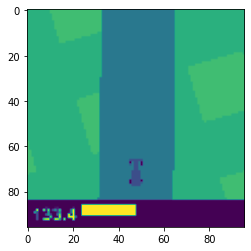

In [8]:
import matplotlib.pyplot as plt
plt.imshow(obs[:,:,0])


In [9]:
env1.close()